In [53]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [55]:
df = pd.read_csv(data)
df.shape

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1815126, 73)

## Logistic Regression 

In [56]:
# New DataFrame for groupnig values
gdf = pd.DataFrame()
gdf['dr_Foreclosure_Ind'] = df['dr_Foreclosure_Ind']

In [57]:
# Manual grouping function
def m_grp(col, bins):
  bin = bins + [df[col].max()]
  labels = bin[:-1]
  gdf[col] = pd.cut(df[col], bin, labels = labels, include_lowest=True).astype(str)
  
# Natural grouping function
def n_grp(col, min, max, interval):
  bin = list(range(min, max, interval)) + [df[col].max()]
  labels = bin[:-1]
#   labels = list(range(len(bin)-1))
  gdf[col] = pd.cut(df[col], bin, labels=labels, include_lowest=True).astype(str)
  
#Equal grouping
# function
def e_grp(col, bins):
  spc = np.linspace(df[col].min(), df[col].max(), bins).tolist()
  bin = [round(x,2) for x in spc]
  labels = bin[:-1]
  gdf[col] = pd.cut(df[col], bin, labels=labels, include_lowest=True).astype(str)

In [58]:
#1.Mortgage1Amount - regrouped 100k-200k and 200k-300k
m_grp('Mortgage1Amount', [0, 50000, 100000, 300000, 400000,500000])
gdf.loc[gdf['Mortgage1Amount'] == 'nan', 'Mortgage1Amount'] = 'NA'
gdf.loc[gdf['Mortgage1Amount'] == '0.0', 'Mortgage1Amount'] = 'LT50K'
gdf.loc[gdf['Mortgage1Amount'] == '50000.0', 'Mortgage1Amount'] = '50K-100K'
gdf.loc[gdf['Mortgage1Amount'] == '100000.0', 'Mortgage1Amount'] = '100K-300K'
gdf.loc[gdf['Mortgage1Amount'] == '300000.0', 'Mortgage1Amount'] = '300K-400K'
gdf.loc[gdf['Mortgage1Amount'] == '400000.0', 'Mortgage1Amount'] = '400K-500K'
gdf.loc[gdf['Mortgage1Amount'] == '500000.0', 'Mortgage1Amount'] = 'GT500K'


#2.AreaBuilding- regrouped LT1000SQFT and 1000-1500SQFT
m_grp('AreaBuilding', [0, 1500, 3000])
# The exposure for LT500 is small and the coefficient is close to 1, so comnibit it with 1000
gdf.loc[gdf['AreaBuilding'] == 'nan', 'AreaBuilding'] = 'NA'
gdf.loc[gdf['AreaBuilding'] == '0.0', 'AreaBuilding'] = 'LT1500SQFT'
gdf.loc[gdf['AreaBuilding'] == '1500.0', 'AreaBuilding'] = '1500-3000SQFT'
gdf.loc[gdf['AreaBuilding'] == '3000.0', 'AreaBuilding'] = 'GT3000SQFT'


#3.E_SQMILES- regrouped 5-9 & 10-19
m_grp('E_SQMILES', [0, 2, 5, 20, 50]) #median 9.27
gdf.loc[gdf['E_SQMILES'] == 'nan', 'E_SQMILES'] = 'NA'
gdf.loc[gdf['E_SQMILES'] == '0', 'E_SQMILES'] = 'LT2SQML'
gdf.loc[gdf['E_SQMILES'] == '2', 'E_SQMILES'] = '2-4SQML'
gdf.loc[gdf['E_SQMILES'] == '5', 'E_SQMILES'] = '5-19QML'
gdf.loc[gdf['E_SQMILES'] == '20','E_SQMILES'] = '20-49SQML'
gdf.loc[gdf['E_SQMILES'] == '50','E_SQMILES'] = 'GT50SQML'


#4.E_DENSITY-regrouped 2500-5K and 5K-10K
m_grp('E_DENSITY', [0, 100, 500, 1000, 2500, 10000, 40000]) #med 2647.1
gdf.loc[gdf['E_DENSITY'] == 'nan', 'E_DENSITY'] = 'NA'
gdf.loc[gdf['E_DENSITY'] == '0', 'E_DENSITY'] = 'LT100'
gdf.loc[gdf['E_DENSITY'] == '100', 'E_DENSITY'] = '100-500'
gdf.loc[gdf['E_DENSITY'] == '500', 'E_DENSITY'] = '500-1K'
gdf.loc[gdf['E_DENSITY'] == '1000', 'E_DENSITY'] = '1K-2500'
gdf.loc[gdf['E_DENSITY'] == '2500', 'E_DENSITY'] = '2500-10K'
gdf.loc[gdf['E_DENSITY'] == '10000', 'E_DENSITY'] = '10K-40K'
gdf.loc[gdf['E_DENSITY'] == '40000', 'E_DENSITY'] = 'GT40K'


#5. E_MEDAGE
m_grp('E_MEDAGE', [0, 25, 35, 45]) #gen Z, millenial, gen x, boomer
# Combine 45 and 55 age group because they have similar coeff
gdf.loc[gdf['E_MEDAGE'] == 'nan', 'E_MEDAGE'] = 'NA'
gdf.loc[gdf['E_MEDAGE'] == '0', 'E_MEDAGE'] = 'LT25YRS'
gdf.loc[gdf['E_MEDAGE'] == '25', 'E_MEDAGE'] = '25-34YRS'
gdf.loc[gdf['E_MEDAGE'] == '35', 'E_MEDAGE'] = '35-45YRS'
gdf.loc[gdf['E_MEDAGE'] == '45', 'E_MEDAGE'] = 'GT45YRS'



#6. E_MEDHHSIZE - regrouped
m_grp('E_MEDHHSIZE', [1, 2, 2.25, 2.5, 2.75, 3, 4]) #median 2.5
# gdf.loc[gdf['E_MEDHHSIZE'] == 'nan', 'E_MEDHHSIZE'] = '2.25'
# Use mode when missing value because NA category's p value by itself is too high, creating a unstable model 
gdf.loc[gdf['E_MEDHHSIZE'] == 'nan', 'E_MEDHHSIZE'] = '1-2.49'
gdf.loc[gdf['E_MEDHHSIZE'] == '1.0', 'E_MEDHHSIZE'] = '1-2.49'
gdf.loc[gdf['E_MEDHHSIZE'] == '2.0', 'E_MEDHHSIZE'] = '1-2.49'
gdf.loc[gdf['E_MEDHHSIZE'] == '2.25', 'E_MEDHHSIZE'] = '1-2.49'
gdf.loc[gdf['E_MEDHHSIZE'] == '2.5', 'E_MEDHHSIZE'] = '2.5-2.99'
gdf.loc[gdf['E_MEDHHSIZE'] == '2.75', 'E_MEDHHSIZE'] = '2.5-2.99'
gdf.loc[gdf['E_MEDHHSIZE'] == '3.0', 'E_MEDHHSIZE'] = '3-4'
gdf.loc[gdf['E_MEDHHSIZE'] == '4.0', 'E_MEDHHSIZE'] = 'GT4'

#7. E_MEDHHINC - regrouped (combine 111677.5 with 167516.25 together)
e_grp('E_MEDHHINC', 5)
gdf.loc[gdf['E_MEDHHINC'] == 'nan', 'E_MEDHHINC'] = 'NA'
gdf.loc[gdf['E_MEDHHINC'] == '0.0', 'E_MEDHHINC'] = 'LT55838.75'
gdf.loc[gdf['E_MEDHHINC'] == '55838.75', 'E_MEDHHINC'] = '55838.75-111677.5'
gdf.loc[gdf['E_MEDHHINC'] == '111677.5', 'E_MEDHHINC'] = 'GT111677.5'
gdf.loc[gdf['E_MEDHHINC'] == '167516.25', 'E_MEDHHINC'] = 'GT111677.5'

#8. dr_House_Age - Note: 25-36YRS,37-48YRS,49-60YRS,61-72YRS have too high p-value and high exposures/counts
  #should we drop it? but house age should have an impact on foreclosure
n_grp('dr_House_Age', min = 1, max = 120, interval=12)
gdf.loc[gdf['dr_House_Age'] == 'nan', 'dr_House_Age'] = 'NA'
gdf.loc[gdf['dr_House_Age'] == '1.0', 'dr_House_Age'] = 'LT13YRS'
gdf.loc[gdf['dr_House_Age'] == '13.0', 'dr_House_Age'] = '13-24YRS'
gdf.loc[gdf['dr_House_Age'] == '25.0', 'dr_House_Age'] = '25-36YRS'
gdf.loc[gdf['dr_House_Age'] == '37.0', 'dr_House_Age'] = '37-48YRS'
gdf.loc[gdf['dr_House_Age'] == '49.0', 'dr_House_Age'] = '49-60YRS'
gdf.loc[gdf['dr_House_Age'] == '61.0', 'dr_House_Age'] = '61-72YRS'
gdf.loc[gdf['dr_House_Age'] == '73.0', 'dr_House_Age'] = '73-84YRS'
gdf.loc[gdf['dr_House_Age'] == '85.0', 'dr_House_Age'] = '85-96YRS'
gdf.loc[gdf['dr_House_Age'] == '97.0', 'dr_House_Age'] = '97-109YRS'
gdf.loc[gdf['dr_House_Age'] == '109.0', 'dr_House_Age'] = 'GT109YRS'

#9. dr_TRAVLTIME
m_grp('dr_TRAVLTIME', [0.00,20.00,25.00,30.00,35.00,40.00,45.00])
gdf.loc[gdf['dr_TRAVLTIME'] == 'nan', 'dr_TRAVLTIME'] = '0.0'


#10.dr_Ownership_Period
m_grp('dr_Ownership_Period', [0, 2, 6, 8, 10, 12, 14])
gdf.loc[gdf['dr_Ownership_Period'] == 'nan', 'dr_Ownership_Period'] = 'NA'
gdf.loc[gdf['dr_Ownership_Period'] == '0', 'dr_Ownership_Period'] = '0-2'
gdf.loc[gdf['dr_Ownership_Period'] == '2', 'dr_Ownership_Period'] = '2-6'
gdf.loc[gdf['dr_Ownership_Period'] == '6', 'dr_Ownership_Period'] = '6-8'
gdf.loc[gdf['dr_Ownership_Period'] == '8', 'dr_Ownership_Period'] = '8-10'
gdf.loc[gdf['dr_Ownership_Period'] == '10', 'dr_Ownership_Period'] = '10-12'
gdf.loc[gdf['dr_Ownership_Period'] == '12', 'dr_Ownership_Period'] = '12-14'
gdf.loc[gdf['dr_Ownership_Period'] == '14', 'dr_Ownership_Period'] = '14-16'


#11. dr_OOCCHH
def modifiede_grp(col, bins):
  bin = np.linspace(df[col].min(), df[col].max(), bins).tolist()
  labels = bin[:-1]
  gdf[col] = pd.cut(df[col], bin, labels=labels, include_lowest=True).astype(str)

df['dr_OOCCHH'] = df['E_OOCCHH']/df['E_HH10']
modifiede_grp('dr_OOCCHH', 5)


#12. E_POP10
m_grp('E_POP10', [0, 19562.67, 29344.0, 39125.33, 48906.67, 58688.0, 68469.33, 78250.67])
gdf.loc[gdf['E_POP10'] == '0', 'E_POP10'] = '0-19562.67'
gdf.loc[gdf['E_POP10'] == '19562.67', 'E_POP10'] = '19562.67-29344.0'
gdf.loc[gdf['E_POP10'] == '29344.0', 'E_POP10'] = '29344.0-39125.33'
gdf.loc[gdf['E_POP10'] == '39125.33', 'E_POP10'] = '39125.33-48906.67'
gdf.loc[gdf['E_POP10'] == '48906.67', 'E_POP10'] = '48906.67-58688.0'
gdf.loc[gdf['E_POP10'] == '58688.0', 'E_POP10'] = '58688.0-68469.33'
gdf.loc[gdf['E_POP10'] == '68469.33', 'E_POP10'] = '68469.33-78250.67'
gdf.loc[gdf['E_POP10'] == '78250.67', 'E_POP10'] = '78250.67-'


#13.
df['dr_PERC_ASSO_ABOVE'] = df['dr_PERC_ASSO_ABOVE'].fillna(value=df['dr_PERC_ASSO_ABOVE'].mean())
e_grp('dr_PERC_ASSO_ABOVE', 5)


#14.
#m_grp('dr_Annual_PopGrowth10', [-4,-2,-1,-0.5,0,0.5,1,2,4])
# -4 an4 have small exposure and -4 has high p value
m_grp('dr_Annual_PopGrowth10', [-2,-1,-0.5,0,0.5,1,2])
#gdf.loc[gdf['dr_Annual_PopGrowth10'] == 'nan', 'dr_Annual_PopGrowth10'] = 'NA' 
gdf.loc[gdf['dr_Annual_PopGrowth10'] == 'nan', 'dr_Annual_PopGrowth10'] = '0.0' 
# Chaneg Null to 0 due to large p value and abnrmal coeff and very small exposure wehn having the NA category
# Also missing value can be interpreted as no population chage 


#15.
gdf['StatusOwnerOccupiedFlag'] = df['StatusOwnerOccupiedFlag'].astype(str)
gdf.loc[gdf['StatusOwnerOccupiedFlag'] == 'nan', 'StatusOwnerOccupiedFlag'] = 'NA'


#16.
m_grp('TaxAssessedImprovementsPerc', [0.0,11.11,22.22,33.33,44.44,55.56,66.67,77.78,88.89])
gdf.loc[gdf['TaxAssessedImprovementsPerc'] == 'nan', 'TaxAssessedImprovementsPerc'] = '0.0'
# No value is similat to having 0 value, belonging to the lowest bucket


#17.
m_grp('TaxAssessedValueLand', [0,11800,23600,35400,47200,59000])
gdf.loc[gdf['TaxAssessedValueLand'] == 'nan', 'TaxAssessedValueLand'] = '0.0'
# No value is similat to having 0 value, belonging to the lowest bucket


#18.
gdf['dr_Value_Change'] = df['dr_Value_Change'].astype(str)
gdf.loc[gdf['dr_Value_Change'] == 'nan', 'dr_Value_Change'] = 'NA'
gdf.loc[gdf['dr_Value_Change'] == 'INC', 'dr_Value_Change'] = 'Increase'
gdf.loc[gdf['dr_Value_Change'] == 'DEC', 'dr_Value_Change'] = 'Decrease'
gdf.loc[gdf['dr_Value_Change'] == 'NC', 'dr_Value_Change'] = 'No change'


#19. E_NOMORT
df['dr_NOMORT'] = df['E_NOMORT']/df['E_HH10']
df['dr_NOMORT'] = df['dr_NOMORT'].fillna(value=df['dr_NOMORT'].mean())
m_grp('dr_NOMORT', [0,0.06, 0.12,0.18,0.24])
gdf.loc[gdf['dr_NOMORT'] == '0.0', 'dr_NOMORT'] = 'LT 6%'
gdf.loc[gdf['dr_NOMORT'] == '0.06', 'dr_NOMORT'] = '6-12%'
gdf.loc[gdf['dr_NOMORT'] == '0.12', 'dr_NOMORT'] = '12-18%'
gdf.loc[gdf['dr_NOMORT'] == '0.18', 'dr_NOMORT'] = '18-24%'
gdf.loc[gdf['dr_NOMORT'] == '0.18', 'dr_NOMORT'] = 'GT 24%'

#20.
gdf['dr_Condo_Ind'] = df['dr_Condo_Ind'].astype(str)
gdf.loc[gdf['dr_Condo_Ind'] == 'nan', 'dr_Condo_Ind'] = 'NA'
gdf.loc[gdf['dr_Condo_Ind'] == '0', 'dr_Condo_Ind'] = 'Not condo'
gdf.loc[gdf['dr_Condo_Ind'] == '1', 'dr_Condo_Ind'] = 'Condo'


#21.
#X_Risk_Score
m_grp('X_Risk_Score', [0,650,700,750,800])
#e_grp('X_Risk_Score', 9)gdf.loc[gdf['X_Bankruptcy_Index'] == 'nan', 'X_Bankruptcy_Index'] = 'NA'
gdf.loc[gdf['X_Risk_Score'] == 'nan', 'X_Risk_Score'] = 'NA'
gdf.loc[gdf['X_Risk_Score'] == '0.0', 'X_Risk_Score'] = 'LT650'
gdf.loc[gdf['X_Risk_Score'] == '650', 'X_Risk_Score'] = '650-700'
gdf.loc[gdf['X_Risk_Score'] == '700', 'X_Risk_Score'] = '700-750'
gdf.loc[gdf['X_Risk_Score'] == '750', 'X_Risk_Score'] = '750-800'
gdf.loc[gdf['X_Risk_Score'] == '800', 'X_Risk_Score'] = 'GT800'

#.
e_grp('E_HH10', 10)
gdf.loc[gdf['E_HH10'] == 'nan', 'E_HH10'] = '0.0'
# No value is similat to having 0 value, belonging to the lowest bucket

In [59]:
gdf.columns

Index(['dr_Foreclosure_Ind', 'Mortgage1Amount', 'AreaBuilding', 'E_SQMILES',
       'E_DENSITY', 'E_MEDAGE', 'E_MEDHHSIZE', 'E_MEDHHINC', 'dr_House_Age',
       'dr_TRAVLTIME', 'dr_Ownership_Period', 'dr_OOCCHH', 'E_POP10',
       'dr_PERC_ASSO_ABOVE', 'dr_Annual_PopGrowth10',
       'StatusOwnerOccupiedFlag', 'TaxAssessedImprovementsPerc',
       'TaxAssessedValueLand', 'dr_Value_Change', 'dr_NOMORT', 'dr_Condo_Ind',
       'X_Risk_Score', 'E_HH10'],
      dtype='object')

In [60]:
gdf.shape

(1815126, 23)

In [61]:
# create training and testing vars - with sample data to test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(gdf, gdf['dr_Foreclosure_Ind'], test_size=0.4, random_state = 123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1089075, 23) (1089075,)
(726051, 23) (726051,)


In [62]:
multi_model = sm.formula.glm("dr_Foreclosure_Ind~C(Mortgage1Amount)+C(AreaBuilding)+C(E_SQMILES)\
                             +C(E_DENSITY)+C(E_MEDAGE)+C(E_MEDHHSIZE)\
                             +C(dr_Annual_PopGrowth10)+C(StatusOwnerOccupiedFlag)\
                             +C(TaxAssessedImprovementsPerc)\
                             +C(TaxAssessedValueLand)\
                             +C(E_POP10)+C(dr_OOCCHH)+C(dr_NOMORT)\
                             +C(E_MEDHHINC)+C(dr_PERC_ASSO_ABOVE)+C(dr_Condo_Ind)+C(dr_Ownership_Period)\
                             +C(dr_House_Age)+C(dr_Value_Change)+C(X_Risk_Score)\
                             +C(dr_TRAVLTIME)"\
                             , data=X_train, family=sm.families.Binomial()).fit()
print(multi_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     dr_Foreclosure_Ind   No. Observations:              1089055
Model:                            GLM   Df Residuals:                  1088958
Model Family:                Binomial   Df Model:                           96
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.2071e+05
Date:                Sun, 11 Aug 2019   Deviance:                   4.4142e+05
Time:                        20:21:18   Pearson chi2:                 1.12e+06
No. Iterations:                     8   Covariance Type:             nonrobust
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -4.5557      0.116    -39.289 

### Prediction

In [18]:
X_test = X_test.drop('dr_Foreclosure_Ind', axis=1)

In [43]:
pred = multi_model.predict(X_test)
pred.mean()

0.06358397010853437

In [44]:
pred.head()

648555    0.030317
627335    0.063079
250574    0.020560
668483    0.004217
263793    0.157845
dtype: float64

In [112]:
prediction = pred.apply(lambda x: 1 if x>=.21 else 0)

In [113]:
prediction.value_counts()

0    687055
1     38996
dtype: int64

In [114]:
y_test.value_counts()

0    679855
1     46196
Name: dr_Foreclosure_Ind, dtype: int64

### Accuracy

In [115]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
print(confusion_matrix(y_pred = prediction, y_true = y_test))
print(accuracy_score(y_pred = prediction, y_true = y_test))

[[652805  27050]
 [ 34250  11946]]
0.9155706692780534


### Decile Tables

In [119]:
pred_prob = pred

In [117]:
predictions = pd.DataFrame(prediction)
pred_scores = pd.DataFrame(columns=['actual','predict','pred_prob'])
pred_scores['actual'] = y_test
pred_scores['predict'] = predictions
pred_scores['pred_prob'] = pd.DataFrame(pred_prob)
pred_scores = pred_scores.sort_values(by='pred_prob',ascending=False)
pred_scores['row_id'] = range(0,0+len(pred_scores))
pred_scores['decile'] = ( pred_scores['row_id'] / (len(pred_scores)/10) ).astype(int)
pred_scores.loc[pred_scores['decile'] == 10]=9
pred_scores['decile'].value_counts()

0    72606
9    72605
8    72605
7    72605
6    72605
5    72605
4    72605
3    72605
2    72605
1    72605
Name: decile, dtype: int64

In [120]:
gains = pred_scores.groupby('decile')['actual'].agg(['count','sum'])
gains.columns = ['count','actual']
gains['pred'] = round(pred_scores.groupby('decile')['pred_prob'].agg(['sum']),0)
gains['actual %'] = gains['actual']/gains['count']
gains['pred %'] = gains['pred']/gains['count']
gains['if_random'] = sum(gains['actual']) /10 
gains['model lift'] = round(gains['pred'] / gains['if_random'],2)*100
gains['A/P'] = round(gains['actual %']/gains['pred %'],3)*100
gains

,count,actual,pred,actual %,pred %,if_random,model lift,A/P
decile,,,,,,,,
0,72606,18094,17500.0,0.249208,0.241027,4619.6,379.0,103.4
1,72605,8525,8865.0,0.117416,0.122099,4619.6,192.0,96.2
2,72605,5688,5922.0,0.078342,0.081565,4619.6,128.0,96.0
3,72605,4142,4263.0,0.057048,0.058715,4619.6,92.0,97.2
4,72605,3133,3151.0,0.043151,0.043399,4619.6,68.0,99.4
5,72605,2313,2342.0,0.031857,0.032257,4619.6,51.0,98.8
6,72605,1730,1713.0,0.023828,0.023593,4619.6,37.0,101.0
7,72605,1223,1215.0,0.016845,0.016734,4619.6,26.0,100.7
8,72605,854,798.0,0.011762,0.010991,4619.6,17.0,107.0


### Factor tables

In [44]:
result_df = pd.DataFrame({'Coef' : multi_model.params, 
                         'p-value' : multi_model.pvalues,
                         'Factor': np.exp(multi_model.params)})
result_df.head()

,Coef,p-value,Factor
Intercept,-4.555654,0.000000e+00,0.010508
C(Mortgage1Amount)[T.300K-400K],0.383288,1.445069e-116,1.467101
C(Mortgage1Amount)[T.400K-500K],0.607551,2.999874e-207,1.835931
C(Mortgage1Amount)[T.50K-100K],-0.197132,1.492564e-26,0.821082
C(Mortgage1Amount)[T.GT500K],0.260244,7.180519e-38,1.297246


#### 18. dr_Value_Change

In [68]:
#bar plot with counts
temp = gdf['dr_Value_Change'].value_counts()
df1 = pd.DataFrame({'dr_Value_Change': temp.index, 'Count': temp.values})
df1

,dr_Value_Change,Count
0,No change,1144595
1,Increase,518991
2,Decrease,151540


  dr_Value_Change    Count
2        Decrease   151540
1        Increase   518991
0       No change  1144595


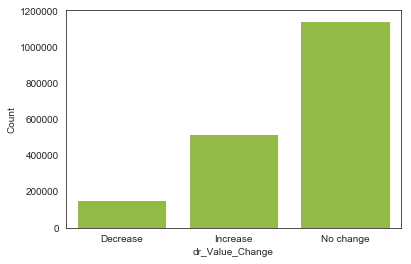

In [69]:
# reorder 
df1 = df1.reindex([2,1,0])
print(df1)
sns.barplot(x = 'dr_Value_Change', y = 'Count', data = df1, color = 'yellowgreen')

In [70]:
df0 = pd.DataFrame({'dr_Value_Change':["Decrease"],
              'Factor':1})
df0

,dr_Value_Change,Factor
0,Decrease,1


In [71]:
df3 = pd.DataFrame({'dr_Value_Change':["Increase","Not change"],
              'Factor':result_df.iloc[84:86,2]})
df3

,dr_Value_Change,Factor
C(dr_Value_Change)[T.Increase],Increase,0.580544
C(dr_Value_Change)[T.No change],Not change,0.569097


In [72]:
df3 = pd.concat([df0,df3])
df3

,dr_Value_Change,Factor
0,Decrease,1.000000
C(dr_Value_Change)[T.Increase],Increase,0.580544
C(dr_Value_Change)[T.No change],Not change,0.569097


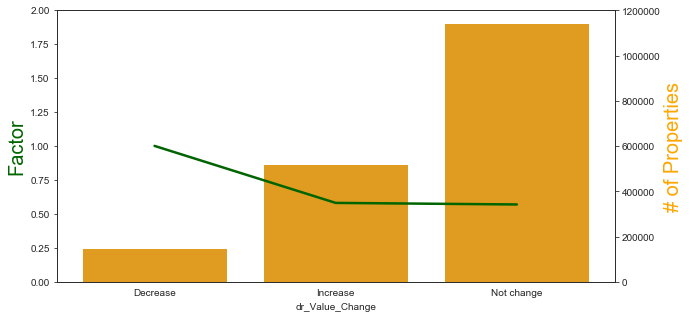

In [75]:
# combine the plot
sns.axes_style('dark')
sns.set_style("white")


fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
    
sns.barplot(ax=ax2, x = 'dr_Value_Change', y='Count', data=df1, color='orange')
df3.plot.line(ax = ax1, x='dr_Value_Change', y  = 'Factor', color = 'darkgreen', legend = None)

plt.setp(ax1.lines,linewidth=2.5)
    
ax1.grid(False)
ax2.grid(False)
    
ax1.set_ylabel('Factor', color='darkgreen',fontsize=20)
ax2.set_ylabel('# of Properties', color='orange',fontsize=20)
    
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax1.set_ylim(0, 2)

    
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### 19. dr_NOMORT

In [76]:
#counts
temp = gdf['dr_NOMORT'].value_counts()
df1 = pd.DataFrame({'dr_NOMORT': temp.index, 'Count': temp.values})
df1

,dr_NOMORT,Count
0,0.24,636551
1,18-24%,541023
2,12-18%,317086
3,6-12%,202889
4,LT 6%,117577


In [77]:
# reorder 
df1 = df1.reindex([4,3,2,1,0])
df1

,dr_NOMORT,Count
4,LT 6%,117577
3,6-12%,202889
2,12-18%,317086
1,18-24%,541023
0,0.24,636551


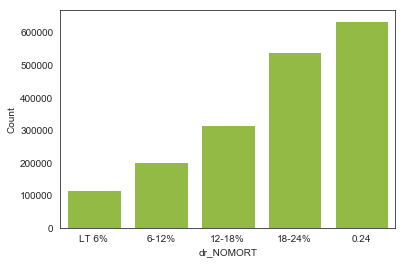

In [78]:
sns.barplot(x = 'dr_NOMORT', y = 'Count', data = df1, color = 'yellowgreen')

In [79]:
df0 = pd.DataFrame({'dr_NOMORT':["GT24%"],
              'Factor':1})
df0

,dr_NOMORT,Factor
0,GT24%,1


In [80]:
a=result_df.iloc[57:61,2]
a

C(dr_NOMORT)[T.12-18%]    1.668064
C(dr_NOMORT)[T.18-24%]    1.277748
C(dr_NOMORT)[T.6-12%]     2.019828
C(dr_NOMORT)[T.LT 6%]     2.937272
Name: Factor, dtype: float64

In [81]:
df3 = pd.DataFrame({'dr_NOMORT':["12-18%","18-24%","6-12%","LT 6%"],
              'Factor':result_df.iloc[57:61,2]})
df3

,dr_NOMORT,Factor
C(dr_NOMORT)[T.12-18%],12-18%,1.668064
C(dr_NOMORT)[T.18-24%],18-24%,1.277748
C(dr_NOMORT)[T.6-12%],6-12%,2.019828
C(dr_NOMORT)[T.LT 6%],LT 6%,2.937272


In [82]:
df3 = pd.concat([df0,df3])
df3

,dr_NOMORT,Factor
0,GT24%,1.000000
C(dr_NOMORT)[T.12-18%],12-18%,1.668064
C(dr_NOMORT)[T.18-24%],18-24%,1.277748
C(dr_NOMORT)[T.6-12%],6-12%,2.019828
C(dr_NOMORT)[T.LT 6%],LT 6%,2.937272


In [83]:
#re-order
df3 = df3.reindex(['C(dr_NOMORT)[T.LT 6%]',
            'C(dr_NOMORT)[T.6-12%]',
             'C(dr_NOMORT)[T.12-18%]',
             'C(dr_NOMORT)[T.18-24%]',
             0])
df3

,dr_NOMORT,Factor
C(dr_NOMORT)[T.LT 6%],LT 6%,2.937272
C(dr_NOMORT)[T.6-12%],6-12%,2.019828
C(dr_NOMORT)[T.12-18%],12-18%,1.668064
C(dr_NOMORT)[T.18-24%],18-24%,1.277748
0,GT24%,1.000000


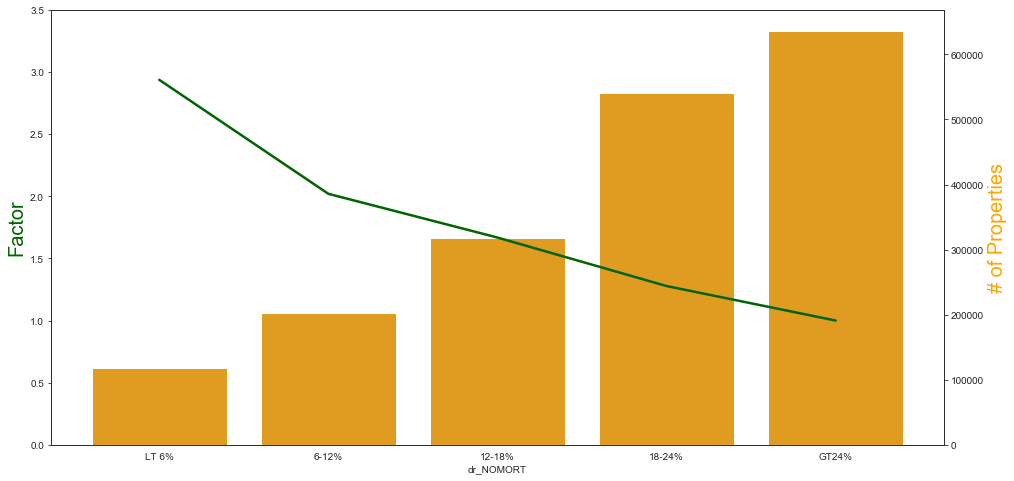

In [84]:
# combine the plot
sns.axes_style('dark')
sns.set_style("white")


fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
    
sns.barplot(ax=ax2, x = 'dr_NOMORT', y='Count', data=df1, color='orange')
df3.plot.line(ax = ax1, x='dr_NOMORT', y  = 'Factor', color = 'darkgreen', legend = None)

plt.setp(ax1.lines,linewidth=2.5)
    
ax1.grid(False)
ax2.grid(False)
    
ax1.set_ylabel('Factor', color='darkgreen',fontsize=20)
ax2.set_ylabel('# of Properties', color='orange',fontsize=20)
    
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax1.set_ylim(0, 3.5)

    
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### 20. dr_condo_ind

In [85]:
#counts
temp = gdf['dr_Condo_Ind'].value_counts()
df1 = pd.DataFrame({'dr_Condo_Ind': temp.index, 'Count': temp.values})
df1

,dr_Condo_Ind,Count
0,Not condo,1649222
1,Condo,165904


In [86]:
df0 = pd.DataFrame({'dr_Condo_Ind':["Condo"],
              'Factor':1})
df0

,dr_Condo_Ind,Factor
0,Condo,1


In [88]:
a=result_df.iloc[66:67,2]
a

C(dr_Condo_Ind)[T.Not condo]    2.832104
Name: Factor, dtype: float64

In [89]:
df3 = pd.DataFrame({'dr_Condo_Ind':["Not condo"],
              'Factor':result_df.iloc[66:67,2]})
df3

,dr_Condo_Ind,Factor
C(dr_Condo_Ind)[T.Not condo],Not condo,2.832104


In [90]:
df3 = pd.concat([df0,df3])
df3

,dr_Condo_Ind,Factor
0,Condo,1.000000
C(dr_Condo_Ind)[T.Not condo],Not condo,2.832104


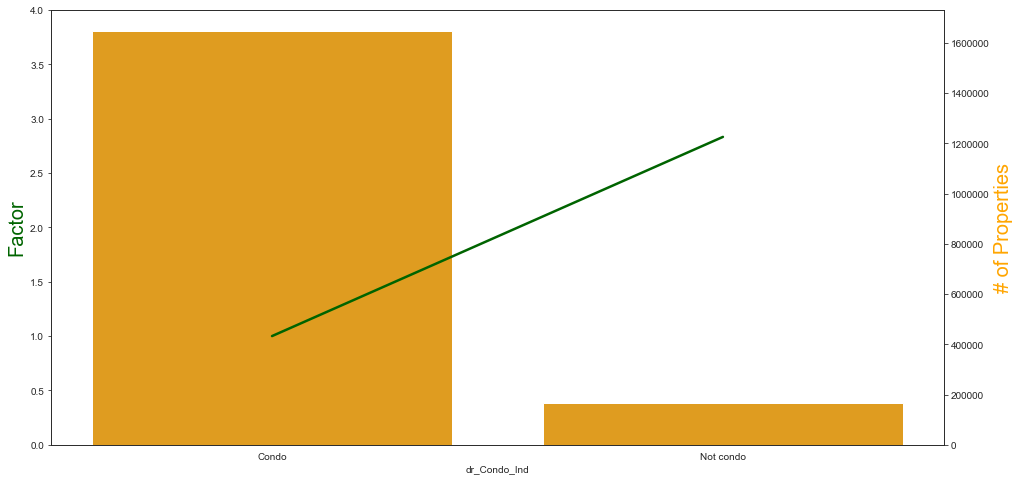

In [91]:
# combine the plot
sns.axes_style('dark')
sns.set_style("white")


fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
    
sns.barplot(ax=ax2, x = 'dr_Condo_Ind', y='Count', data=df1, color='orange')
df3.plot.line(ax = ax1, x='dr_Condo_Ind', y  = 'Factor', color = 'darkgreen', legend = None)

plt.setp(ax1.lines,linewidth=2.5)
    
ax1.grid(False)
ax2.grid(False)
    
ax1.set_ylabel('Factor', color='darkgreen',fontsize=20)
ax2.set_ylabel('# of Properties', color='orange',fontsize=20)
    
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax1.set_ylim(0, 4)
    
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### 21. X_Risk_Score

In [92]:
#counts
temp = gdf['X_Risk_Score'].value_counts()
df1 = pd.DataFrame({'X_Risk_Score': temp.index, 'Count': temp.values})
df1

,X_Risk_Score,Count
0,750.0,634930
1,700.0,627400
2,650.0,292200
3,LT650,117185
4,NA,110429
5,800.0,32982


In [93]:
# reorder 
df1 = df1.reindex([3,2,0,1,5,4])
df1

,X_Risk_Score,Count
3,LT650,117185
2,650.0,292200
0,750.0,634930
1,700.0,627400
5,800.0,32982
4,NA,110429


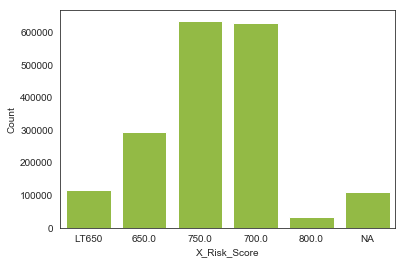

In [94]:
sns.barplot(x = 'X_Risk_Score', y = 'Count', data = df1, color = 'yellowgreen')

In [97]:
a=result_df.iloc[86:91,2]
a

C(X_Risk_Score)[T.700.0]    0.653725
C(X_Risk_Score)[T.750.0]    0.347221
C(X_Risk_Score)[T.800.0]    0.130020
C(X_Risk_Score)[T.LT650]    1.293751
C(X_Risk_Score)[T.NA]       0.299273
Name: Factor, dtype: float64

In [98]:
df0 = pd.DataFrame({'X_Risk_Score':["650-700"],
              'Factor':1})
df0

,X_Risk_Score,Factor
0,650-700,1


In [102]:
df3 = pd.DataFrame({'X_Risk_Score':["700-750","750-800","GT800","LT650","NA"],
              'Factor':result_df.iloc[86:91,2]})
df3

,X_Risk_Score,Factor
C(X_Risk_Score)[T.700.0],700-750,0.653725
C(X_Risk_Score)[T.750.0],750-800,0.347221
C(X_Risk_Score)[T.800.0],GT800,0.130020
C(X_Risk_Score)[T.LT650],LT650,1.293751
C(X_Risk_Score)[T.NA],NA,0.299273


In [103]:
df3 = pd.concat([df0,df3])
df3

,X_Risk_Score,Factor
0,650-700,1.000000
C(X_Risk_Score)[T.700.0],700-750,0.653725
C(X_Risk_Score)[T.750.0],750-800,0.347221
C(X_Risk_Score)[T.800.0],GT800,0.130020
C(X_Risk_Score)[T.LT650],LT650,1.293751
C(X_Risk_Score)[T.NA],NA,0.299273


In [104]:
#re-order
df3 = df3.reindex(['C(X_Risk_Score)[T.LT650]',
             0,
             'C(X_Risk_Score)[T.700.0]',
             'C(X_Risk_Score)[T.750.0]',
             'C(X_Risk_Score)[T.800.0]',
             'C(X_Risk_Score)[T.NA]'])
df3

,X_Risk_Score,Factor
C(X_Risk_Score)[T.LT650],LT650,1.293751
0,650-700,1.000000
C(X_Risk_Score)[T.700.0],700-750,0.653725
C(X_Risk_Score)[T.750.0],750-800,0.347221
C(X_Risk_Score)[T.800.0],GT800,0.130020
C(X_Risk_Score)[T.NA],NA,0.299273


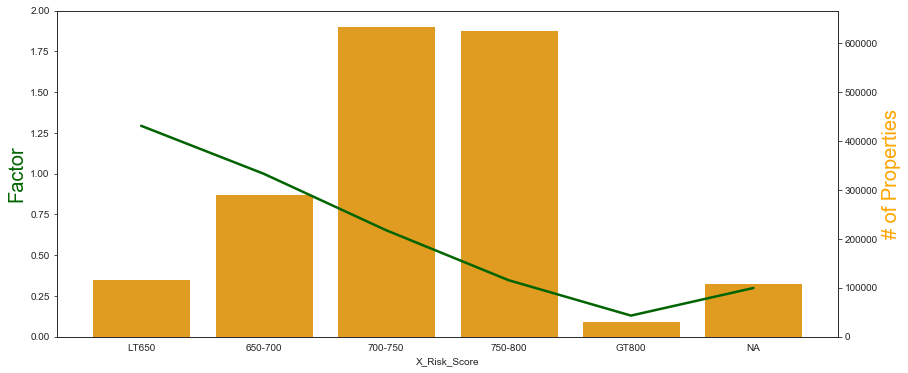

In [105]:
# combine the plot
sns.axes_style('dark')
sns.set_style("white")


fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()
    
sns.barplot(ax=ax2, x = 'X_Risk_Score', y='Count', data=df1, color='orange')
df3.plot.line(ax = ax1, x='X_Risk_Score', y  = 'Factor', color = 'darkgreen', legend = None)

plt.setp(ax1.lines,linewidth=2.5)
    
ax1.grid(False)
ax2.grid(False)
    
ax1.set_ylabel('Factor', color='darkgreen',fontsize=20)
ax2.set_ylabel('# of Properties', color='orange',fontsize=20)
    
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax1.set_ylim(0, 2)
    
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()